In [84]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image, ImageOps, ImageMath
from astropy.utils.data import download_file
from mpol.__init__ import zenodo_record
from mpol import coordinates, gridding, fourier, losses, precomposed, utils
from mpol.images import ImageCube
import importlib

import training_func
importlib.reload(training_func)
import plotting_func
importlib.reload(plotting_func)

<module 'plotting_func' from '/Users/behzadbojnordiarbab/Projects_Local/Chalmers_PhD/Machine-Learning-Imaging/scripts/plotting_func.py'>

In [104]:
###########################################################################################
def RML_imager(visibility_file, cell_size, npix, learning_rate, hyperparams_config, start_from_dirty_image=False, learning_rate_dim=None, n_iter_dim=None,):
    '''---------------------------------------------------------------------------------------
    Performs the RML imaging process using the SimpleNet model on the input visibilities
    to produce surface brightness maps of the source in the image plane. Currently uses
    only the NLL loss function, without other regularizers.

    # TODO:
    1. Start the training loop from the dirty image instead of a flat BaseCube. #*DONE*#
    2. Implement regularizers in the loss function. #*DONE*#
    3. Optimise regularisers to improve the quality of the final image.
    4. Use cross-validation to find the best hyperparameters for the RML imaging process.
    5. Compare the final image with that from CASA tclean.
    6. Add functionality to save the final image cube as a FITS file.
    7. Look into how to image multi-channel continuum visibilities into a single channel image.
    ----------------------------------------------------------------------------------------'''

    # create a directory to store the outputs of the RML imaging process
    if not os.path.exists('RML_loop_outputs/'):
        os.makedirs('RML_loop_outputs/')

    # load the mock visibilities from the .npz file
    d = np.load(visibility_file)
    uu = d["uu"][0]
    vv = d["vv"][0]
    # plt.scatter(uu, vv, s=1, c='black', marker='.')
    # plt.show()
    weight = d["weight"][0]
    data = d["data"][0]
    data_re = np.real(data)
    data_im = np.imag(data)
    nvis = len(uu)
    print(f'Loaded visibilities from {visibility_file}.')
    print(f'The dataset has {nvis} visibilities.\n')

    # check if the input cell size Nyquist samples the spatial frequency represented by the maximum u,v value
    max_uv = np.max(np.array([uu,vv]))
    max_cell_size = utils.get_maximum_cell_size(max_uv)
    if cell_size > max_cell_size:
        raise ValueError(f'The input cell size ({cell_size} arcseconds) does not Nyquist sample the spatial frequency represented by the maximum u,v value.\nThe maximum cell_size that will still Nyquist sample the spatial frequency represented by the maximum u,v value is {max_cell_size:.2f} arcseconds).\nPlease change the cell size to be less than {max_cell_size:.2f} arcseconds.\n')
    else:
        print(f'The input cell size ({cell_size} arcseconds) Nyquist samples the spatial frequency represented by the maximum u,v value.\n(The maximum cell_size that will still Nyquist sample the spatial frequency represented by the maximum u,v value is {max_cell_size:.2f} arcseconds).\n')

    # plot and save the downloaded (u,v) distribution
    plotting_func.plot_uv_distribution(uu, vv)

    # instantiate the gridcoords object
    coords = coordinates.GridCoords(cell_size=cell_size, npix=npix)


    ###########################################################################################
    # instantiate the dirty imager object
    imager = gridding.DirtyImager(
        coords=coords,
        uu=uu,
        vv=vv,
        weight=weight,
        data_re=data_re,
        data_im=data_im,
    )

    # calculate the dirty image and the beam using Briggs weighting with robust=0.0
    img, beam = imager.get_dirty_image(weighting="briggs", robust=0.0)
    print(f"Calculated dirty beam and dirty image using Briggs weighting with robust=0.0.")

    # plot and save the calculated dirty image and dirty beam
    chan = 0
    plotting_func.plot_dirty(imager, img, beam, chan)
    ###########################################################################################


    # instantiate the data averager object
    averager = gridding.DataAverager(
        coords=coords,
        uu=uu,
        vv=vv,
        weight=weight,
        data_re=data_re,
        data_im=data_im,
        )

    # convert the gridded visibilities to a pytorch dataset
    dset = averager.to_pytorch_dataset(max_scatter=1.5)
    print('Gridded and converted visibilities to a pytorch dataset.')
    print(f"The dataset has {dset.nchan} channel(s).\n") # TODO: Look into how to image multi-channel continuum visibilities into a single channel image.

    if start_from_dirty_image:
        ###-----------------------------------------------------------------------------------------------------------------###
        rml_dim=training_func.seed_from_dirty_image(learning_rate_dim, n_iter_dim, coords, img, dset)
        ###-----------------------------------------------------------------------------------------------------------------###

    # initialise SimpleNet
    rml = precomposed.SimpleNet(coords=coords, nchan=dset.nchan)
    print(f"SimpleNet network initialised.")

    # choose the model image to set as the initial BaseCube
    if start_from_dirty_image:
        # load the optimised initial model image (BaseCube) from the .pt file
        rml.load_state_dict(torch.load("RML_loop_outputs/dirty_image_model.pt"))
        print('Using optimised initial model image (loaded from: RML_loop_outputs/dirty_image_model.pt) based on the dirty image as the initial BaseCube image\n')
    else:
        # use the default flat initial model image in the BaseCube
        print('Starting from the default flat initial model image (BaseCube).\n')

    # Because we want to compute a clean set of gradient values in a later step, we “zero out” any gradients attached to the tensor components so that they aren’t counted twice.
    rml.zero_grad()

    # instantiate the SGD optimizer
    optimizer = torch.optim.Adam(rml.parameters(), lr=learning_rate)
    # optimizer.zero_grad()

    start_time = time.time()
    ###~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~###
    # Run the training loop
    print("Starting the optimisation loop with {} iterations...".format(hyperparams_config["epochs"]))
    loss_tracker=training_func.train(hyperparams_config, dset, rml, optimizer)
    print("loss tracker: ", loss_tracker)
    ###~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~###
    end_time = time.time()
    print('Done.')

    # calculate the time taken for the optimisation loop to finish
    elapsed_time = end_time - start_time
    print(f"The optimisation loop finished in {elapsed_time:.2f} seconds.\n")

    # print the initial and final loss values
    print(f"Initial loss: {loss_tracker[0]:.2f}")
    print(f"Final loss: {loss_tracker[-1]:.2f}\n")

    # plot the loss per iteration
    plotting_func.plot_loss_per_iter(hyperparams_config, loss_tracker)

    # detach the model 'sky' image from the computational graph and convert it to a numpy array
    img_cube = rml.icube.sky_cube.detach().numpy() # TODO: Add functionality to save this image cube as a FITS file

    # plot the final model image after the last iteration
    plotting_func.plot_final_image(rml, img_cube)

    return img_cube
###########################################################################################

In [111]:
# input parameters
###########################################################################################################################################
"""For mock data"""
# visibility_file = '../data/visibilities/mock_visibilities_model_star_new.npz' # path to the .npz file containing the observed visibilities
# cell_size = 0.03 # arcseconds

"""For RDor data"""
# visibility_file = '../data/visibilities/RDor_spw3_fixvis.npz' # path to the .npz file containing the observed visibilities
# visibility_file = '../data/visibilities/RDor_spw0.split.fixvis.averaged.npz' # path to the .npz file containing the observed visibilities
# cell_size = 0.001 # arcseconds

"""for HD143006 data"""
# visibility_file = download_file(
#     "https://zenodo.org/record/4904794/files/HD143006_continuum.npz",
#     cache=True,
#     pkgname="mpol",
# )

"""For ALMA logo"""
visibility_file = download_file(
    f"https://zenodo.org/record/{zenodo_record}/files/logo_cube.noise.npz",
    cache=True,
    show_progress=True,
    pkgname="mpol",
)
cell_size = 0.01 # arcseconds



npix = 1024 # number of pixels per image axis
learning_rate = 0.5 # learning rate for the optimizer
# n_iter = 25 # number of iterations for the optimizer

# hyperparameters used in the function and the optimizer (set those not being used to 0)
hyperparams_config = (
    # {"lambda_sparsity": 7.0e-05,
    # "lambda_TV": 0.00,
    # "entropy": 1e-03,
    # "prior_intensity": 1.5e-07,
    # "TSV": 0.00,
    # "epochs": 1000,
    # }
    # {'lambda_sparsity': 1.e-4,
    #     'lambda_TV': 1.e-4,
    #     'entropy': 1.e-03,
    #     'prior_intensity': 1.0e-07,
    #     'TSV': 1.0e-03,
    #     "epochs": 1000,}
    {'lambda_sparsity': 1.e-2,
        'lambda_TV': 0,
        'entropy': 0.3,
        'prior_intensity': 1.0e-0,
        'TSV': 1e-2,
        "epochs": 600}
)

start_from_dirty_image = True # If True, the initial BaseCube image is set to the dirty image, else to the default flat image.
###########################################################################################################################################

Loaded visibilities from /Users/behzadbojnordiarbab/.mpol/cache/download/url/58292501b4b512df5580c7c0dd5d9da7/contents.
The dataset has 325080 visibilities.

The input cell size (0.01 arcseconds) Nyquist samples the spatial frequency represented by the maximum u,v value.
(The maximum cell_size that will still Nyquist sample the spatial frequency represented by the maximum u,v value is 0.09 arcseconds).

(u,v) distribution plot saved to: RML_loop_outputs/uv_distribution.pdf

Calculated dirty beam and dirty image using Briggs weighting with robust=0.0.
Dirty beam and dirty image plot saved to: RML_loop_outputs/dirty_beam_and_dirty_image.pdf
The dirty image contains 525509 negative pixels.

Gridded and converted visibilities to a pytorch dataset.
The dataset has 1 channel(s).

Starting the optimisation loop with 500 iterations to optimise the initial model image (BaseCube) based on the dirty image...
Loss per iteration (for optimising the BaseCube image to the dirty image) plot saved to: 

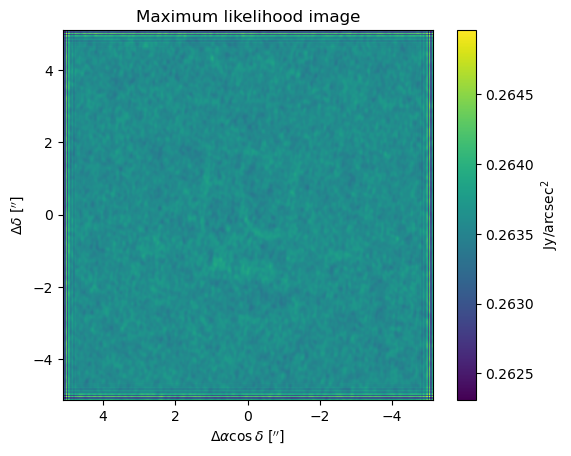

In [112]:
# function call
###########################################################################################################################################
img_cube = RML_imager(visibility_file=visibility_file, cell_size=cell_size, npix=npix, learning_rate=learning_rate, hyperparams_config=hyperparams_config, start_from_dirty_image = start_from_dirty_image, learning_rate_dim=5, n_iter_dim=500)
###########################################################################################################################################

In [88]:
(4**4)*15/60


64.0